# LTSF-Linear 구현
- 이 코드에서는 KOSPI 200 종목 중 하나인 삼성전자의 종가 데이터를 예측해보고 실제 데이터와 비교
- DLinear를 이용해 추세(trend) 및 계절성(seasonal) 유무 판단

In [1]:
import yfinance as yf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
samsung = yf.download(f'005930.KS', start='2000-01-01', end='2023-06-01', interval='1d') # Valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

[*********************100%***********************]  1 of 1 completed


In [3]:
train_df = samsung[:int(len(samsung) * 0.8)]
test_df = samsung[int(len(samsung) * 0.8):]

In [4]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

train_df.rename(columns={'Date':'datetime'}, inplace=True)
test_df.rename(columns={'Date':'datetime'}, inplace=True)

c:\Users\choi\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
train_df = train_df[['datetime', 'Close']]
test_df = test_df[['datetime','Close']]

In [6]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 

In [7]:
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)
    

class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [8]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 24
batch_size = 32
targets = 'Close'
date = 'datetime'

train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'datetime', targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:int(len(train_df) * 0.8)], train_y[:int(len(train_df) * 0.8)])
valid_ds = Data(train_x[int(len(train_df) * 0.8):], train_y[int(len(train_df) * 0.8):])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[int(len(train_df) * 0.8):].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001

DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

NLinear_model = LTSF_NLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss()
model = DLinear_model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 1e9

if model == DLinear_model:
    model_name = 'DLinear_model'
else:
    model_name = 'NLinear_model'

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(model, f'{model_name}.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        nlinear_best_epoch = epoch
        nlinear_best_train_loss = np.mean(loss_list)
        nlinear_best_valid_loss = np.mean(valid_loss.item())
        nlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  2%|▏         | 2/100 [00:00<00:13,  7.13it/s]

valid_loss=0.040, test_los0.130, Model Save
epoch = 1, train_loss : 0.013, valid_loss : 0.040, test_loss : 0.130
valid_loss=0.033, test_los0.109, Model Save
epoch = 2, train_loss : 0.007, valid_loss : 0.033, test_loss : 0.109


  4%|▍         | 4/100 [00:00<00:11,  8.40it/s]

epoch = 3, train_loss : 0.006, valid_loss : 0.034, test_loss : 0.113
valid_loss=0.029, test_los0.098, Model Save
epoch = 4, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.098


  6%|▌         | 6/100 [00:00<00:10,  8.81it/s]

valid_loss=0.029, test_los0.097, Model Save
epoch = 5, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.097
valid_loss=0.028, test_los0.093, Model Save
epoch = 6, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


  8%|▊         | 8/100 [00:00<00:10,  9.04it/s]

epoch = 7, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.097
epoch = 8, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.094


 10%|█         | 10/100 [00:01<00:09,  9.01it/s]

epoch = 9, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.100
valid_loss=0.027, test_los0.091, Model Save
epoch = 10, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 12%|█▏        | 12/100 [00:01<00:10,  8.71it/s]

epoch = 11, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.093
epoch = 12, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093


 15%|█▌        | 15/100 [00:01<00:09,  9.11it/s]

epoch = 13, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090
epoch = 14, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.099
epoch = 15, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.095


 17%|█▋        | 17/100 [00:01<00:08,  9.35it/s]

epoch = 16, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.095
valid_loss=0.027, test_los0.090, Model Save
epoch = 17, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090


 19%|█▉        | 19/100 [00:02<00:08,  9.37it/s]

valid_loss=0.027, test_los0.090, Model Save
epoch = 18, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 19, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 22%|██▏       | 22/100 [00:02<00:08,  9.36it/s]

epoch = 20, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.096
epoch = 21, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.102
epoch = 22, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 24%|██▍       | 24/100 [00:02<00:08,  9.48it/s]

epoch = 23, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.099
epoch = 24, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.094


 26%|██▌       | 26/100 [00:02<00:07,  9.49it/s]

epoch = 25, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090
epoch = 26, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.097


 28%|██▊       | 28/100 [00:03<00:08,  8.91it/s]

epoch = 27, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.092
epoch = 28, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092


 31%|███       | 31/100 [00:03<00:07,  9.23it/s]

epoch = 29, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.099
epoch = 30, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.095
epoch = 31, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.096


 34%|███▍      | 34/100 [00:03<00:06,  9.61it/s]

epoch = 32, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.102
epoch = 33, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092
epoch = 34, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.100


 36%|███▌      | 36/100 [00:04<00:07,  8.86it/s]

valid_loss=0.027, test_los0.089, Model Save
epoch = 35, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089
epoch = 36, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 38%|███▊      | 38/100 [00:04<00:06,  9.27it/s]

epoch = 37, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089
epoch = 38, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.094


 40%|████      | 40/100 [00:04<00:06,  9.42it/s]

epoch = 39, train_loss : 0.006, valid_loss : 0.033, test_loss : 0.109
epoch = 40, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 42%|████▏     | 42/100 [00:04<00:07,  7.88it/s]

epoch = 41, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 42, train_loss : 0.005, valid_loss : 0.032, test_loss : 0.106


 44%|████▍     | 44/100 [00:04<00:06,  8.28it/s]

epoch = 43, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 44, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.099


 47%|████▋     | 47/100 [00:05<00:05,  9.18it/s]

epoch = 45, train_loss : 0.005, valid_loss : 0.031, test_loss : 0.104
epoch = 46, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.092
epoch = 47, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.100


 49%|████▉     | 49/100 [00:05<00:05,  9.41it/s]

epoch = 48, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.091
epoch = 49, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


 51%|█████     | 51/100 [00:05<00:05,  8.99it/s]

epoch = 50, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.097
valid_loss=0.027, test_los0.090, Model Save
epoch = 51, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 54%|█████▍    | 54/100 [00:05<00:04,  9.33it/s]

epoch = 52, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093
epoch = 53, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.090
epoch = 54, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 56%|█████▌    | 56/100 [00:06<00:04,  9.23it/s]

epoch = 55, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.100
epoch = 56, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.092


 58%|█████▊    | 58/100 [00:06<00:04,  8.47it/s]

epoch = 57, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.096
epoch = 58, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.097


 60%|██████    | 60/100 [00:06<00:04,  8.12it/s]

epoch = 59, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.096
epoch = 60, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093


 62%|██████▏   | 62/100 [00:06<00:04,  8.72it/s]

epoch = 61, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092
epoch = 62, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090


 64%|██████▍   | 64/100 [00:07<00:04,  8.66it/s]

epoch = 63, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091
epoch = 64, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 66%|██████▌   | 66/100 [00:07<00:03,  8.93it/s]

epoch = 65, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 66, train_loss : 0.005, valid_loss : 0.034, test_loss : 0.116


 69%|██████▉   | 69/100 [00:07<00:03,  9.42it/s]

epoch = 67, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.101
epoch = 68, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.094
epoch = 69, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.096


 71%|███████   | 71/100 [00:07<00:03,  8.90it/s]

epoch = 70, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090
epoch = 71, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.092


 73%|███████▎  | 73/100 [00:08<00:03,  8.87it/s]

epoch = 72, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 73, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.101


 75%|███████▌  | 75/100 [00:08<00:02,  8.92it/s]

epoch = 74, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093
epoch = 75, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.089


 77%|███████▋  | 77/100 [00:08<00:02,  8.43it/s]

epoch = 76, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090
epoch = 77, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.104


 79%|███████▉  | 79/100 [00:08<00:02,  8.53it/s]

epoch = 78, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 79, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.093


 81%|████████  | 81/100 [00:09<00:02,  8.38it/s]

epoch = 80, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.104
epoch = 81, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.098


 83%|████████▎ | 83/100 [00:09<00:01,  8.62it/s]

epoch = 82, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 83, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.093


 85%|████████▌ | 85/100 [00:09<00:01,  8.53it/s]

epoch = 84, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 85, train_loss : 0.006, valid_loss : 0.032, test_loss : 0.108


 87%|████████▋ | 87/100 [00:09<00:01,  8.79it/s]

epoch = 86, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.091
epoch = 87, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 89%|████████▉ | 89/100 [00:10<00:01,  8.30it/s]

epoch = 88, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089
epoch = 89, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.091


 91%|█████████ | 91/100 [00:10<00:01,  8.46it/s]

epoch = 90, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.093
epoch = 91, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.098


 93%|█████████▎| 93/100 [00:10<00:00,  8.76it/s]

epoch = 92, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.101
epoch = 93, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 95%|█████████▌| 95/100 [00:10<00:00,  8.99it/s]

epoch = 94, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091
epoch = 95, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 97%|█████████▋| 97/100 [00:10<00:00,  9.17it/s]

epoch = 96, train_loss : 0.005, valid_loss : 0.033, test_loss : 0.110
epoch = 97, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.098


 99%|█████████▉| 99/100 [00:11<00:00,  9.14it/s]

epoch = 98, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 99, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.095


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]

epoch = 100, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.103


In [9]:
best_model = torch.load('DLinear_model.pth')
best_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        output = best_model(data)
        predictions = output.squeeze().numpy()
        actual_values = target.numpy()

def inverse_standardization(data, mean, std):
    return (data * std) + mean

predictions_original = inverse_standardization(predictions, mean_, std_)
actual_values_original = inverse_standardization(actual_values, mean_, std_)

### 예측 그래프와 실제 그래프 시각화(Visualization)
- 일부 구간 비교(24 step를 예측했으므로 비교 구간의 길이는 24)

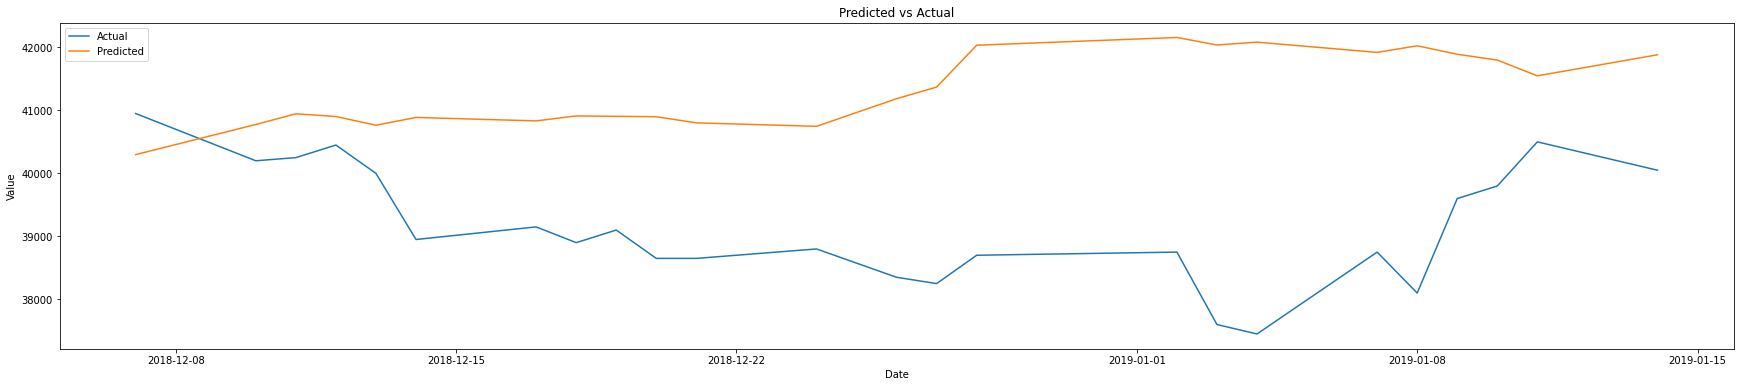

In [10]:
section_idx = 0
interval = forcast_size

plt.figure(figsize=(30, 6))
plt.plot(test_date[section_idx, :interval].flatten(), actual_values_original[section_idx, :interval].flatten(), label='Actual')
plt.plot(test_date[section_idx, :interval].flatten(), predictions_original[section_idx, :interval].flatten(), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

### DLinear의 가중치를 이용한 삼성전자 종가 데이터의 추세 및 계절성 시각화
- 주가 데이터라 그런지 추세와 계절성이 뚜렷하지는 않음

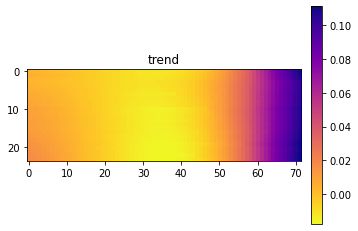

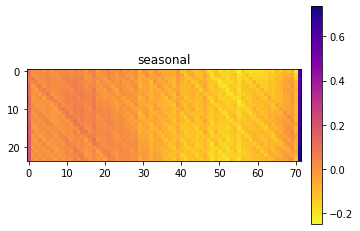

In [11]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():  
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()